In [29]:
import numpy as np
import pandas as pd

import spotipy
import spotipy.oauth2 as oauth2
import datetime as dt
from tqdm import tqdm_notebook

import time
import Levenshtein

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
client_id='fb007fbf1d564626b64fbd240a0c8c78'
client_secret='57b642506eb8484db3a92535b1e7d073'
credentials = oauth2.SpotifyClientCredentials(
        client_id=client_id,
        client_secret=client_secret)

token = credentials.get_access_token()
spotify = spotipy.Spotify(auth=token)

In [89]:
def split_artist_string(artist):
    remove_char = ['.']
    for cha in remove_char:
        artist = artist.replace(cha, '')
    
    chars = [' and ', '&', ' x ', ' with ', '/', ';', ',', 'featuring',
             'feautring', 'featurring', ' ft ', ' feat ', ' + ', ' vs ', ' y ']
    
    sub_arr = []
    splits = artist.lower().split('(')
    for spl in splits:
        sub_arr += spl.split(')')
    artists = sub_arr
    
    #artists = artist.lower().split(' and ')
    # split by &
    for cha in chars:
        art_subs = []
        for art in artists:
            art_subs += art.lower().split(cha)
        artists = art_subs
    
    art_subs = []
    for art in artists:
        if art[:5] == 'with ':
            art_subs += [art[5:].strip()]
        else:
            art_subs += [art.strip()]
    
    artists = art_subs
    
    art_subs = []
    for art in artists:
        if art != '':
            art_subs += [art]
    artists = art_subs
    
    art_subs = []
    for art in artists:
        art = art.strip()
        art_subs += [art]
        
        add_str = art
        add_str_flag = False
        if 'the ' == add_str[:4]:
            add_str = add_str[4:]
            add_str_flag = True
        if ' the' == add_str[:4]:
            add_str = add_str[:-4]
            add_str_flag = True
        if ' the ' in add_str:
            add_str = add_str.replace(' the ', ' ')
            add_str_flag = True
        
        if add_str_flag:
            art_subs += [add_str]
            
    artists = art_subs
    
    return artists

def split_song_string(song):
    song = song.lower()
    remove_char = ['.', '-', "'"] + [' part {}'.format(i) for i in range(1,10)] + [' pt {}'.format(i) for i in range(1,10)]
    remove_char += ['part i', 'part ii', 'part iii']
    for cha in remove_char:
        song = song.replace(cha, '')

    if '(' in song:
        sub_arr = []
        splits = song.split('(')
        for spl in splits:
            sub_arr += spl.split(')')
        songs = sub_arr
    else:
        songs = [song]
        
    return songs

def pick_best_track(song, artist, tracks):
    track_artist_strings = []
    track_names = []
    total_dists = []
    track_urls = []
    for track in tracks:
        if True:#('remix' in track['name'].lower()) == ('remix' in song.lower()) and (' live ' in track['name'].lower()) == (' live ' in song.lower()):
            track_artists = track['artists']
            track_artist_strings += [" ".join([art['name'] for art in track_artists])]
            track_names += [track['name']]

            track_song_dist = Levenshtein.distance(song.lower().strip(), track_names[-1].lower().strip())
            track_artist_dist = Levenshtein.distance(artist.lower().strip(), track_artist_strings[-1].lower().strip())

            total_dists += [track_song_dist + track_artist_dist]

            #popularity = track['popularity']
            #track_album_name = track['album']['name']
            #track_id = track['id']

            track_urls += [track['external_urls']['spotify']]
    if len(track_urls) == 0:
        return 0,0,0,0,0,False
    else:
        best_ind = np.argmin(np.asarray(total_dists))
        return track_artist_strings[best_ind], track_names[best_ind], total_dists[best_ind], track_urls[best_ind], best_ind, True

## Make DF

In [7]:
df_seperate = pd.read_csv('./CombinedChartsUnique_AllBillboard.csv')
df_sep_debut = df_seperate[df_seperate.columns[4::7].tolist()].copy()
df_sep_debut[df_sep_debut.isna()] = '0'

In [8]:
def date2year(date_str):
    year = int(date_str.split('/')[-1])
    if (year >= 0) and (year <=20):
        year += 2000
    else:
        year += 1900
    return year

In [9]:
date_strings = df_sep_debut.max(axis=1)
date_years = np.asarray([date2year(date_string) for date_string in date_strings])
#pd.DataFrame(columns=['Debut Date', 'Debut Year'], data=[date_strings, date_years])
date_years

array([2017, 2012, 2004, ..., 1998, 2004, 1983])

In [10]:
date_strings = df_sep_debut.max(axis=1)
date_years = np.asarray([date2year(date_string) for date_string in date_strings])

date_strings_df = pd.DataFrame(columns=['Debut Date'], data=date_strings)
date_years_df = pd.DataFrame(columns=['Debut Year'], data=date_years)

new_df = pd.concat([df_seperate[['Title', 'Artist']], date_strings_df, date_years_df],  axis=1, sort=False)

In [14]:
new_df.sort_values(by='Debut Year', ascending=False, inplace=True)
new_df = new_df.reset_index(drop=True)
new_df.to_csv('new_df.csv')
new_df

,Title,Artist,Debut Date,Debut Year
0,Forever Yours (Tribute),Kygo With Avicii & Sandro Cavazza,2/8/20,2020
1,Safe,Neon Feather Featuring Chris Cron,1/11/20,2020
2,This Bar,Morgan Wallen,1/18/20,2020
3,"Alone, Pt. II",Alan Walker & Ava Max,1/11/20,2020
4,Break My Baby,KALEO,2/1/20,2020
5,Simmer,Hayley Williams,2/1/20,2020
6,20/20,Lil Tjay,1/18/20,2020
7,Enough,Social Club Misfits Featuring Austin French,1/11/20,2020
8,Godzilla,Eminem Featuring Juice WRLD,2/1/20,2020
9,Bring My Flowers Now,Tanya Tucker,2/8/20,2020


## Make Playlist

In [15]:
new_df = pd.read_csv('new_df.csv')

In [18]:
token = credentials.get_access_token()
spotify = spotipy.Spotify(auth=token)
elapsed_time = 0
start_time = time.time()

worked_methods = []
track_artists_all = []
track_names_all = []
total_dists_all = []
track_urls_all = []

year_fails = {}
for year in range(1958, 2021):
    year_fails[year] = 0

In [26]:
song, artist, year, new_df[['Title', 'Artist', 'Debut Year']].values[27124+9005+20891]

('Lovey Dovey',
 'Buddy Knox',
 1960,
 array(['Lovey Dovey', 'Buddy Knox', 1960], dtype=object))

In [27]:
token = credentials.get_access_token()
spotify = spotipy.Spotify(auth=token)
for song, artist, year in tqdm_notebook(new_df[['Title', 'Artist', 'Debut Year']].values):
    
    q = "artist:{} track:{}".format(artist, song)

    try:
        res = spotify.search(q, limit=10, offset=0, type='track', market=None)
    except:
        token = credentials.get_access_token()
        spotify = spotipy.Spotify(auth=token)
        res = spotify.search(q, limit=10, offset=0, type='track', market=None)

    tracks = res['tracks']['items']
    
    if len(tracks) > 0:
        worked_methods += [1]
        track_artist, track_name, total_dist, track_url, best_ind, use_ = pick_best_track(song, artist, tracks)
        if use_:
            track_artists_all += [track_artist]
            track_names_all += [track_name]
            total_dists_all += [total_dist]
            track_urls_all += [track_url]
            
        else:
            worked_methods[-1] = np.nan
            track_artists_all += [np.nan]
            track_names_all += [np.nan]
            total_dists_all += [np.nan]
            track_urls_all += [np.nan]
            year_fails[year] += 1
    else:
        worked_methods += [np.nan]
        track_artists_all += [np.nan]
        track_names_all += [np.nan]
        total_dists_all += [np.nan]
        track_urls_all += [np.nan]
        year_fails[year] += 1

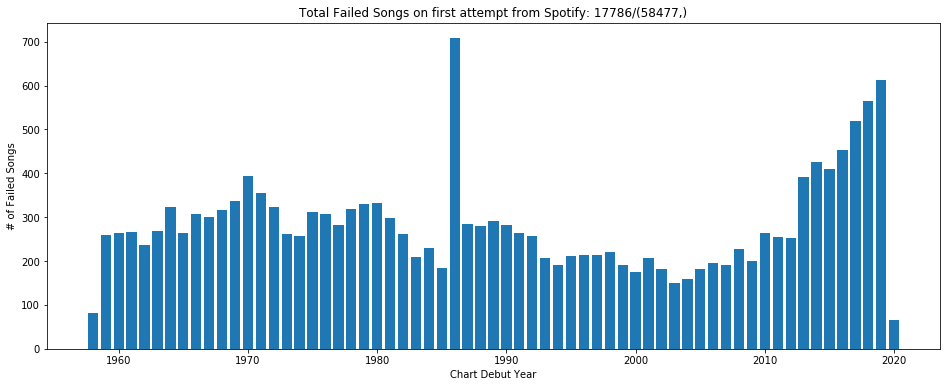

In [30]:
x = np.arange(1958, 2021)
year_fails_vec = np.asarray([year_fails[year] for year in x])
fig, ax = plt.subplots(1,1,figsize=(16,6))
ax.bar(x, year_fails_vec)
ax.set_ylabel('# of Failed Songs')
ax.set_xlabel('Chart Debut Year')
ax.set_title('Total Failed Songs on first attempt from Spotify: {}/{}'.format(year_fails_vec.sum(), 
                                                                              new_df['Title'].values.shape))
plt.show()

In [92]:
res = spotify.search("artist:james blake track:ill come too", limit=10, offset=0, type='track', market=None)
tracks = res['tracks']['items']
tracks

[{'album': {'album_type': 'album',
   'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/53KwLdlmrlCelAZMaLVZqU'},
     'href': 'https://api.spotify.com/v1/artists/53KwLdlmrlCelAZMaLVZqU',
     'id': '53KwLdlmrlCelAZMaLVZqU',
     'name': 'James Blake',
     'type': 'artist',
     'uri': 'spotify:artist:53KwLdlmrlCelAZMaLVZqU'}],
   'available_markets': ['AD',
    'AE',
    'AR',
    'AT',
    'AU',
    'BE',
    'BG',
    'BH',
    'BO',
    'BR',
    'CA',
    'CH',
    'CL',
    'CO',
    'CR',
    'CY',
    'CZ',
    'DE',
    'DK',
    'DO',
    'DZ',
    'EC',
    'EE',
    'EG',
    'ES',
    'FI',
    'FR',
    'GB',
    'GR',
    'GT',
    'HK',
    'HN',
    'HU',
    'ID',
    'IE',
    'IL',
    'IN',
    'IS',
    'IT',
    'JO',
    'JP',
    'KW',
    'LB',
    'LI',
    'LT',
    'LU',
    'LV',
    'MA',
    'MC',
    'MT',
    'MX',
    'MY',
    'NI',
    'NL',
    'NO',
    'NZ',
    'OM',
    'PA',
    'PE',
    'PH',
    'PL',
    'PS',
   

In [101]:
extra_cols_df = pd.DataFrame(list(zip(worked_methods, track_artists_all, 
                                      track_names_all, total_dists_all, track_urls_all)), 
                             columns=['Method','Track Artist','Track Title', 'Lev Dist', 'URL'])
total_df = pd.concat([new_df[new_df.columns[1:]], extra_cols_df],  axis=1)
total_df.to_csv('master_df_take1_3-17-2020.csv')
total_df

,Title,Artist,Debut Date,Debut Year,Method,Track Artist,Track Title,Lev Dist,URL
0,Forever Yours (Tribute),Kygo With Avicii & Sandro Cavazza,2/8/20,2020,2.0,Kygo Avicii Sandro Cavazza,Forever Yours - Avicii Tribute,17.0,https://open.spotify.com/track/3o1CUVeHIid49sa...
1,Safe,Neon Feather Featuring Chris Cron,1/11/20,2020,2.0,Neon Feather Chris Cron,Safe,10.0,https://open.spotify.com/track/6fd7OPOmtanX1n4...
2,This Bar,Morgan Wallen,1/18/20,2020,1.0,Morgan Wallen,This Bar,0.0,https://open.spotify.com/track/7oSq5fbsFkTS9ze...
3,"Alone, Pt. II",Alan Walker & Ava Max,1/11/20,2020,2.0,Alan Walker Ava Max,"Alone, Pt. II",2.0,https://open.spotify.com/track/0bMbDctzMmTyK2j...
4,Break My Baby,KALEO,2/1/20,2020,1.0,KALEO,Break My Baby,0.0,https://open.spotify.com/track/5NnFkbEjahUGx5T...
5,Simmer,Hayley Williams,2/1/20,2020,1.0,Hayley Williams,Simmer,0.0,https://open.spotify.com/track/2Ew2BRBsCNAYlbg...
6,20/20,Lil Tjay,1/18/20,2020,1.0,Lil Tjay,20/20,0.0,https://open.spotify.com/track/4Hqh0dS4x07zuRw...
7,Enough,Social Club Misfits Featuring Austin French,1/11/20,2020,2.0,Social Club Misfits Austin French,Enough,10.0,https://open.spotify.com/track/3YmPKB2cXJ9e0Zu...
8,Godzilla,Eminem Featuring Juice WRLD,2/1/20,2020,2.0,Eminem Juice WRLD,Godzilla (feat. Juice WRLD),29.0,https://open.spotify.com/track/7FIWs0pqAYbP91W...
9,Bring My Flowers Now,Tanya Tucker,2/8/20,2020,1.0,Tanya Tucker,Bring My Flowers Now,0.0,https://open.spotify.com/track/7nx130yomv3fvvF...


## Method 2

In [103]:
non_inds = np.where(np.isnan(np.asarray(worked_methods)))[0]

year_fails_adjusted = year_fails

token = credentials.get_access_token()
spotify = spotipy.Spotify(auth=token)

for ind in tqdm_notebook(non_inds):
    song, artist, year = new_df[['Title', 'Artist', 'Debut Year']].values[ind]

    artists = split_artist_string(artist)
    
    total_tracks = []
    for art in artists:
        q = "artist:{} track:{}".format(art, song)
        try:
            res = spotify.search(q, limit=10, offset=0, type='track', market=None)
        except:
            token = credentials.get_access_token()
            spotify = spotipy.Spotify(auth=token)
            res = spotify.search(q, limit=10, offset=0, type='track', market=None)
        tracks = res['tracks']['items']
        total_tracks += tracks
    
    if len(total_tracks) == 0:
        songs = split_song_string(song)
        if len(songs) > 1:
            for art in artists:
                for sng in songs:
                    q = "artist:{} track:{}".format(art, sng)
                    try:
                        res = spotify.search(q, limit=10, offset=0, type='track', market=None)
                    except:
                        token = credentials.get_access_token()
                        spotify = spotipy.Spotify(auth=token)
                        res = spotify.search(q, limit=10, offset=0, type='track', market=None)
                    tracks = res['tracks']['items']
                    total_tracks += tracks

    if len(total_tracks) > 0:
        track_artist, track_name, total_dist, track_url, best_ind, use_ = pick_best_track(song, 
                                                                                          artist, 
                                                                                          total_tracks)
        if use_:
            track_artists_all[ind] = track_artist
            track_names_all[ind] = track_name
            total_dists_all[ind] = total_dist
            track_urls_all[ind] = track_url
            worked_methods[ind] = 2
            year_fails_adjusted[year] -= 1
        else:
            pass#print(artist, artists, song, songs, 'use')
    else:
        pass#print(artist, artists, song, songs, 'len0')

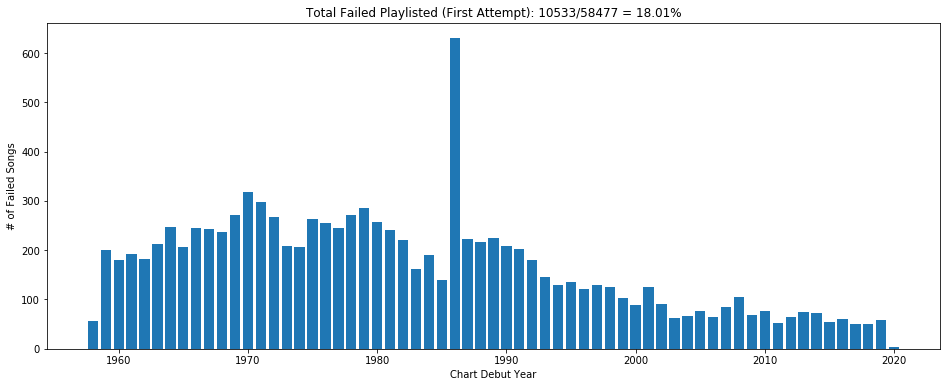

In [104]:
x = np.arange(1958, 2021)
year_fails_vec = np.asarray([year_fails_adjusted[year] for year in x])
fig, ax = plt.subplots(1,1,figsize=(16,6))
ax.bar(x, year_fails_vec)
ax.set_ylabel('# of Failed Songs')
ax.set_xlabel('Chart Debut Year')
ax.set_title('Total Failed Playlisted (First Attempt): {}/{} = {:.2f}%'.format(year_fails_vec.sum(), 
                                                                              new_df['Title'].values.shape[0], 
                                                                            year_fails_vec.sum()/new_df['Title'].values.shape[0]*100))
plt.show()

In [105]:
extra_cols_df = pd.DataFrame(list(zip(worked_methods, track_artists_all, 
                                      track_names_all, total_dists_all, track_urls_all)), 
                             columns=['Method','Track Artist','Track Title', 'Lev Dist', 'URL'])
total_df = pd.concat([new_df[new_df.columns[1:]], extra_cols_df],  axis=1)
total_df.to_csv('master_df_take2_3-17-2020.csv')
total_df

,Title,Artist,Debut Date,Debut Year,Method,Track Artist,Track Title,Lev Dist,URL
0,Forever Yours (Tribute),Kygo With Avicii & Sandro Cavazza,2/8/20,2020,2.0,Kygo Avicii Sandro Cavazza,Forever Yours - Avicii Tribute,17.0,https://open.spotify.com/track/3o1CUVeHIid49sa...
1,Safe,Neon Feather Featuring Chris Cron,1/11/20,2020,2.0,Neon Feather Chris Cron,Safe,10.0,https://open.spotify.com/track/6fd7OPOmtanX1n4...
2,This Bar,Morgan Wallen,1/18/20,2020,1.0,Morgan Wallen,This Bar,0.0,https://open.spotify.com/track/7oSq5fbsFkTS9ze...
3,"Alone, Pt. II",Alan Walker & Ava Max,1/11/20,2020,2.0,Alan Walker Ava Max,"Alone, Pt. II",2.0,https://open.spotify.com/track/0bMbDctzMmTyK2j...
4,Break My Baby,KALEO,2/1/20,2020,1.0,KALEO,Break My Baby,0.0,https://open.spotify.com/track/5NnFkbEjahUGx5T...
5,Simmer,Hayley Williams,2/1/20,2020,1.0,Hayley Williams,Simmer,0.0,https://open.spotify.com/track/2Ew2BRBsCNAYlbg...
6,20/20,Lil Tjay,1/18/20,2020,1.0,Lil Tjay,20/20,0.0,https://open.spotify.com/track/4Hqh0dS4x07zuRw...
7,Enough,Social Club Misfits Featuring Austin French,1/11/20,2020,2.0,Social Club Misfits Austin French,Enough,10.0,https://open.spotify.com/track/3YmPKB2cXJ9e0Zu...
8,Godzilla,Eminem Featuring Juice WRLD,2/1/20,2020,2.0,Eminem Juice WRLD,Godzilla (feat. Juice WRLD),29.0,https://open.spotify.com/track/7FIWs0pqAYbP91W...
9,Bring My Flowers Now,Tanya Tucker,2/8/20,2020,1.0,Tanya Tucker,Bring My Flowers Now,0.0,https://open.spotify.com/track/7nx130yomv3fvvF...


## Method 3

In [115]:
non_inds = np.where(np.isnan(np.asarray(worked_methods)))[0]

year_fails_adjusted = year_fails

token = credentials.get_access_token()
spotify = spotipy.Spotify(auth=token)

for ind in tqdm_notebook(non_inds):
    song, artist, year = new_df[['Title', 'Artist', 'Debut Year']].values[ind]

    artists = split_artist_string(artist)
    
    total_tracks = []
    added_ids = []
    songs = split_song_string(song)
    for sng in songs:
        if len(sng.strip()) > 0:
            q = "track:{}".format(sng)
            try:
                res = spotify.search(q, limit=10, offset=0, type='track', market=None)
            except:
                token = credentials.get_access_token()
                spotify = spotipy.Spotify(auth=token)
                res = spotify.search(q, limit=10, offset=0, type='track', market=None)
            tracks = res['tracks']['items']
            #total_tracks += tracks
            for trk in tracks:
                if trk['id'] not in added_ids:
                    added_ids += [trk['id']]
                    total_tracks += [trk]


            q = sng
            try:
                res = spotify.search(q, limit=10, offset=0, type='track', market=None)
            except:
                token = credentials.get_access_token()
                spotify = spotipy.Spotify(auth=token)
                res = spotify.search(q, limit=10, offset=0, type='track', market=None)
            tracks = res['tracks']['items']
            #total_tracks += tracks
            for trk in tracks:
                if trk['id'] not in added_ids:
                    added_ids += [trk['id']]
                    total_tracks += [trk]

    if len(total_tracks) > 0:
        track_artist, track_name, total_dist, track_url, best_ind, use_ = pick_best_track(song, 
                                                                                          artist, 
                                                                                          total_tracks)
        if use_:
            track_artists_all[ind] = track_artist
            track_names_all[ind] = track_name
            total_dists_all[ind] = total_dist
            track_urls_all[ind] = track_url
            worked_methods[ind] = 3
            year_fails_adjusted[year] -= 1
        else:
            print(artist, artists, song, songs, 'use')
    else:
        print(artist, artists, song, songs, 'len0')

Passion ['passion'] There Is Nothing Our God Can't ['there is nothing our god cant'] len0
Trap City ['trap city'] Yodeling Walmart Kid EDM ['yodeling walmart kid edm'] len0
21 Savage & Metro Boomin ['21 savage', 'metro boomin'] My Choppa Hate N****s ['my choppa hate n****s'] len0
The Killers Featuring Jimmy Kimmel ['the killers', 'killers', 'jimmy kimmel'] Joel The Lump Of Coal ['joel the lump of coal'] len0
Elvis Crespo Featuring Pitbull ['elvis crespo', 'pitbull'] Sopa de Caracol - Yupi ['sopa de caracol  yupi'] len0
Ono ['ono'] Walking On Thin Ice 2013 ['walking on thin ice 2013'] len0
Pesado ['pesado'] Cielo Azul, Cielo Nublado aka Cielo Nevado ['cielo azul, cielo nublado aka cielo nevado'] len0
Larry Hernandez ['larry hernandez'] El Piloto Canavis ['el piloto canavis'] len0
Kiko Rodriguez ['kiko rodriguez'] Quede Solo En La Pobreza ['quede solo en la pobreza'] len0
JAY-Z ['jay-z'] Jockin' JAY-Z ['jockin jayz'] len0
Randy Owen ['randy owen'] Like I Never Broke Her Heart ['like i ne

Xscape Featuring MC Lyte ['xscape', 'mc lyte'] Can't Hang/Do You Want To ['cant hang/do you want to'] len0
Monica ['monica'] Why I Love You So Much/Ain't Nobody ['why i love you so much/aint nobody'] len0
Kilo ['kilo'] Nasty Dancer/White Horse ['nasty dancer/white horse'] len0
The Cranberries ['the cranberries', 'cranberries'] When You're Gone/Free To Decide ['when youre gone/free to decide'] len0
De La Soul ['de la soul'] The Bizness/Stakes Is High ['the bizness/stakes is high'] len0
Jay-Z Featuring Foxxy Brown ['jay-z', 'foxxy brown'] Ain't No Nigga/Dead Presidents ['aint no nigga/dead presidents'] len0
Los Fugitivos ['los fugitivos'] Voy A Intentarlo Todo ['voy a intentarlo todo'] len0
Paco Barron Y Sus Nortenos Clan ['paco barron', 'sus nortenos clan'] Potpourri De Quique ['potpourri de quique'] len0
Sparx ['sparx'] Quiero Volver El Tiempo A Tras ['quiero volver el tiempo a tras'] len0
Bronco: El Gigante De America ['bronco: el gigante de america'] Ojos Que Han Llorado ['ojos que h

Pirates Of The Mississippi ['pirates of the mississippi', 'pirates of mississippi'] Till I'm Holding You Again ['till im holding you again'] len0
Leaders Of The New School ['leaders of the new school', 'leaders of new school'] The Int'l Zone Coaster ['the intl zone coaster'] len0
Elisa Fiorillo ['elisa fiorillo'] Oooh This I Need ['oooh this i need'] len0
Guillermo Davila ['guillermo davila'] Yo Nesecito Mas De Ti ['yo nesecito mas de ti'] len0
T.C.F. ['tcf'] If You Wanna Sex Me Up ['if you wanna sex me up'] len0
Gerald Alston ['gerald alston'] Getting Back Into Love ['getting back into love'] len0
Candyman ['candyman'] 1-800-Sky-Talk PIN #110279 ['1800skytalk pin #110279'] len0
Angel Javier ['angel javier'] Quiero Amarte Al Aire Libre ['quiero amarte al aire libre'] len0
Molly & The Heymakers ['molly', 'the heymakers', 'heymakers'] Chasin' Something Called Love ['chasin something called love'] len0
Kool Moe Dee ['kool moe dee'] How Kool Can One Black Man Be ['how kool can one black ma

Girls Next Door ['girls next door'] Love Will Get You Through Times With No Money ['love will get you through times with no money'] len0
Johnny Paycheck ['johnny paycheck'] Don't Bury Me 'til I'm Ready ['dont bury me til im ready'] len0
Michael Johnson ['michael johnson'] Gotta Learn To Love Without You ['gotta learn to love without you'] len0
Robin Lee ['robin lee'] If You're Anything Like Your Eyes ['if youre anything like your eyes'] len0
Isaac Hayes ['isaac hayes'] Ike's Rap/Hey Girl ['ikes rap/hey girl'] len0
Curtie & The Boom Box ['curtie', 'the boom box', 'boom box'] Black Kisses Never Make You Blue ['black kisses never make you blue'] len0
Johnny Gill ['johnny gill'] Can't Wait Til Tommorow ['cant wait til tommorow'] len0
Peter Wolf ['peter wolf'] OO-EE-Diddley-Bop ['ooeediddleybop'] len0
The Maines Brothers Band ['the maines brothers band', 'maines brothers band'] Everybody Needs Love On Saturday Night ['everybody needs love on saturday night'] len0
Chance ['chance'] She Told 

Kieran Kane ['kieran kane'] I'll Be Your Man Around The House/blue Over You ['ill be your man around the house/blue over you'] len0
Rick Bowles ['rick bowles'] Too Good To Turn Back Now ['too good to turn back now'] len0
Barbara Mandrell ['barbara mandrell'] Operator, Long Distance Please ['operator, long distance please'] len0
The Evasions ['the evasions', 'evasions'] Wikkawrap ['wikkawrap'] len0
Larry Gatlin & The Gatlin Brothers ['larry gatlin', 'the gatlin brothers', 'gatlin brothers'] Wind Is Bound To Change ['wind is bound to change'] len0
Donna Washington ['donna washington'] 'scuse Me, While I Fall In Love ['scuse me, while i fall in love'] len0
Wayne Kemp ['wayne kemp'] Your Wife Is Cheatin' On Us Again ['your wife is cheatin on us again'] len0
Bobby Goldsboro ['bobby goldsboro'] Alice Doesn't Love Here Anymore ['alice doesnt love here anymore'] len0
Eddy Arnold ['eddy arnold'] Bally-Hoo Days/Two Hearts Beat Better Than One ['ballyhoo days/two hearts beat better than one'] len

Earl Scruggs Revue ['earl scruggs revue'] I Could Sure Use The Feeling ['i could sure use the feeling'] len0
Cooper Brothers Band ['cooper brothers band'] I'll Know Her When I See Her ['ill know her when i see her'] len0
Peaches & Herb ['peaches', 'herb'] Roller-Skatin' Mate (Part I) ['rollerskatin mate ', '', ''] len0
Joe Sun ['joe sun'] I'd Rather Go On Hurtin' ['id rather go on hurtin'] len0
High Inergy ['high inergy'] Shoulda Gone Dancin' ['shoulda gone dancin'] len0
Jerry Lee Lewis ['jerry lee lewis'] Rockin' My Life Away/i Wish I Was Eighteen Again ['rockin my life away/i wish i was eighteen again'] len0
Dolly Parton ['dolly parton'] Sweet Summer Lovin'/great Balls Of Fire ['sweet summer lovin/great balls of fire'] len0
Bobby Lewis ['bobby lewis'] She's Been Keepin' Me Up Nights ['shes been keepin me up nights'] len0
Keith Herman ['keith herman'] She's Got A Whole Number ['shes got a whole number'] len0
Bobby So Fine Butler ['bobby so fine butler'] Cheaper Crude Or No More Food [

David Rogers ['david rogers'] I Love What My Woman Does To Me ['i love what my woman does to me'] len0
Alan O'Day ["alan o'day"] Started Out Dancing, Ended Up Making Love ['started out dancing, ended up making love'] len0
Grace Jones ['grace jones'] Sorry/That's The Trouble ['sorry/thats the trouble'] len0
Undisputed Truth ['undisputed truth'] You + Me = Love/Let's Go Down To The Disco ['you + me = love/lets go down to the disco'] len0
Hodges, James And Smith ['hodges', 'james', 'smith'] Since I Fell For You/I'm Falling In Love ['since i fell for you/im falling in love'] len0
Klaatu ['klaatu'] Sub-rosa Subway/calling Occupants ['subrosa subway/calling occupants'] len0
The Emotions ['the emotions', 'emotions'] I Don't Wanna Lose Your Love/Flowers ['i dont wanna lose your love/flowers'] len0
Thom Bresh ['thom bresh'] That Old Cold Shoulder ['that old cold shoulder'] len0
Don Gibson ['don gibson'] Fan The Flame, Feed The Fire ['fan the flame, feed the fire'] len0
Merle Haggard ['merle hag

The Reflections ['the reflections', 'reflections'] Three Steps From True Love ['three steps from true love'] len0
Roy C ['roy c'] Love Me Till Tomorrow Comes ['love me till tomorrow comes'] len0
Ringo Starr ['ringo starr'] No No Song/snookeroo ['no no song/snookeroo'] len0
Joe Stampley ['joe stampley'] Billy Get Me A Woman ['billy get me a woman'] len0
Firefly ['firefly'] Hey There Little Firefly Part I ['hey there little firefly '] len0
The Pointer Sisters ['the pointer sisters', 'pointer sisters'] Live Your Life Before You Die ['live your life before you die'] len0
Linda Ronstadt ['linda ronstadt'] It Doesn't Matter Anymore/When Will I Be Loved ['it doesnt matter anymore/when will i be loved'] len0
B.T. Express ['bt express'] Give It What You Got/Peace Pipe ['give it what you got/peace pipe'] len0
Tavares ['tavares'] Remember What I Told You To Forget/My Ship ['remember what i told you to forget/my ship'] len0
Hank Snow ['hank snow'] Merry-Go-Round Of Love ['merrygoround of love'] le

Jerry Washington ['jerry washington'] Right Here Is Where You Belong ['right here is where you belong'] len0
Elvis Presley ['elvis presley'] Raised On Rock/For Ol' Times Sake ['raised on rock/for ol times sake'] len0
James Brown ['james brown'] I Got Ants In My Pants - Part 1 <P6>and i want to dance ['i got ants in my pants  <p6>and i want to dance'] len0
Jerry Wallace ['jerry wallace'] Sound Of Goodbye/The Song Nobody Sings ['sound of goodbye/the song nobody sings'] len0
Bobby Wright ['bobby wright'] Lovin' Someone On My Mind ['lovin someone on my mind'] len0
Marty Robbins ['marty robbins'] Love Me/Crawling On My Knees ['love me/crawling on my knees'] len0
Tommy Cash ['tommy cash'] She Met A Stranger, I Met A Train ['she met a stranger, i met a train'] len0
Dorsey Burnette ['dorsey burnette'] I Let Another Good One Get Away ['i let another good one get away'] len0
Archie Bell & The Drells ['archie bell', 'the drells', 'drells'] Ain't Nothing For A Man In Love/You Never Know What's On 

Tom T. Hall ['tom t hall'] Ode To A Half A Pound Of Ground Round ['ode to a half a pound of ground round'] len0
Patti Page ['patti page'] Think Again/A Woman Left Lonely ['think again/a woman left lonely'] len0
The Glass House ['the glass house', 'glass house'] Look What We've Done To Love ['look what weve done to love'] len0
Tom Jones ['tom jones'] Puppet Man/Resurrection Shuffle ['puppet man/resurrection shuffle'] len0
George Harrison ['george harrison'] Bangla-Desh/Deep Blue ['bangladesh/deep blue'] len0
The Stairsteps ['the stairsteps', 'stairsteps'] Didn't It Look So Easy ['didnt it look so easy'] len0
Elvis Presley ['elvis presley'] There Goes My Everything/I Really Don't Want To Know ['there goes my everything/i really dont want to know'] len0
The Electric Express ['the electric express', 'electric express'] It's The Real Thing - Pt. I ['its the real thing  pt i'] len0
Inez Foxx ['inez foxx'] You Shouldn't Have Set My Soul On Fire ['you shouldnt have set my soul on fire'] len0
M

Peggy Sue ['peggy sue'] All American Husband ['all american husband'] len0
Brook Benton ['brook benton'] Rainy Night In Georgia/Rubberneckin' ['rainy night in georgia/rubberneckin'] len0
The 5th Dimension ['the 5th dimension', '5th dimension'] A Change Is Gonna Come & People Gotta Be Free/The Declaration ['a change is gonna come & people gotta be free/the declaration'] len0
Barbara Mason ['barbara mason'] Raindrops Keep Fallin' On My Head/If You Knew Him Like I Do ['raindrops keep fallin on my head/if you knew him like i do'] len0
John Wesley Ryles, I ['john wesley ryles', 'i'] I've Just Been Wasting My Time ['ive just been wasting my time'] len0
The Guess Who ['the guess who', 'guess who'] American Woman/No Sugar Tonight ['american woman/no sugar tonight'] len0
The Emotions ['the emotions', 'emotions'] Stealing Love/When Tomorrow Comes ['stealing love/when tomorrow comes'] len0
The Glass House ['the glass house', 'glass house'] Stealing Moments From Another Woman's Life/If It Ain't Lo

Jim Ed Brown ['jim ed brown'] Ginger Is Gentle And Waiting For Me/Drink Boys, Drink ['ginger is gentle and waiting for me/drink boys, drink'] len0
Bobby Lewis ['bobby lewis'] Each And Every Part Of Me ['each and every part of me'] len0
The Happenings ['the happenings', 'happenings'] Where Do I Go/Be-In/Hare Krishna ['where do i go/bein/hare krishna'] len0
Bobby Cole ['bobby cole'] Mister Bo Jangles ['mister bo jangles'] len0
Effie Smith ['effie smith'] Harper Valley P.T.A. Gossip ['harper valley pta gossip'] len0
Roger S. ['roger s'] Culman, Alabam ['culman, alabam'] len0
Wilburn Brothers ['wilburn brothers'] We Need A Lot More Happiness ['we need a lot more happiness'] len0
Johnny Sea ['johnny sea'] Three Six Packs, Two Arms And A Juke Box ['three six packs, two arms and a juke box'] len0
Bill Cosby ['bill cosby'] Funky North Philly ['funky north philly'] len0
Andy Kim ['andy kim'] Shoot'em Up, Baby ['shootem up, baby'] len0
J.R. Bailey ['jr bailey'] Love Won't Wear Off (As The Years 

The Spats Featuring Dick Johnson ['the spats', 'spats', 'dick johnson'] Gator Tails And Monkey Ribs ['gator tails and monkey ribs'] len0
Margie ['margie'] No Thanks, I Just Had One ['no thanks, i just had one'] len0
Slim Whitman ['slim whitman'] Tell Me Pretty Words ['tell me pretty words'] len0
Jim Nesbitt ['jim nesbitt'] Looking For More In '64 ['looking for more in 64'] len0
The Searchers ['the searchers', 'searchers'] Some Day We're Gonna Love Again ['some day were gonna love again'] len0
Glenn Barber ['glenn barber'] If Anyone Can Show Cause ['if anyone can show cause'] len0
Louisiana Red ['louisiana red'] I'm Too Poor To Die ['im too poor to die'] len0
Lawton Williams ['lawton williams'] Everything's O.K. On The LBJ ['everythings ok on the lbj'] len0
Hank Williams Jr. ['hank williams jr'] Guess What, That's Right, She's Gone ['guess what, thats right, shes gone'] len0
Jerry Wallace ['jerry wallace'] It's A Cotton Candy World ['its a cotton candy world'] len0
Billy Grammer ['billy

In [116]:
extra_cols_df = pd.DataFrame(list(zip(worked_methods, track_artists_all, 
                                      track_names_all, total_dists_all, track_urls_all)), 
                             columns=['Method','Track Artist','Track Title', 'Lev Dist', 'URL'])
total_df = pd.concat([new_df[new_df.columns[1:]], extra_cols_df],  axis=1)
total_df.to_csv('master_df_take3_3-17-2020.csv')
total_df

,Title,Artist,Debut Date,Debut Year,Method,Track Artist,Track Title,Lev Dist,URL
0,Forever Yours (Tribute),Kygo With Avicii & Sandro Cavazza,2/8/20,2020,2.0,Kygo Avicii Sandro Cavazza,Forever Yours - Avicii Tribute,17.0,https://open.spotify.com/track/3o1CUVeHIid49sa...
1,Safe,Neon Feather Featuring Chris Cron,1/11/20,2020,2.0,Neon Feather Chris Cron,Safe,10.0,https://open.spotify.com/track/6fd7OPOmtanX1n4...
2,This Bar,Morgan Wallen,1/18/20,2020,1.0,Morgan Wallen,This Bar,0.0,https://open.spotify.com/track/7oSq5fbsFkTS9ze...
3,"Alone, Pt. II",Alan Walker & Ava Max,1/11/20,2020,2.0,Alan Walker Ava Max,"Alone, Pt. II",2.0,https://open.spotify.com/track/0bMbDctzMmTyK2j...
4,Break My Baby,KALEO,2/1/20,2020,1.0,KALEO,Break My Baby,0.0,https://open.spotify.com/track/5NnFkbEjahUGx5T...
5,Simmer,Hayley Williams,2/1/20,2020,1.0,Hayley Williams,Simmer,0.0,https://open.spotify.com/track/2Ew2BRBsCNAYlbg...
6,20/20,Lil Tjay,1/18/20,2020,1.0,Lil Tjay,20/20,0.0,https://open.spotify.com/track/4Hqh0dS4x07zuRw...
7,Enough,Social Club Misfits Featuring Austin French,1/11/20,2020,2.0,Social Club Misfits Austin French,Enough,10.0,https://open.spotify.com/track/3YmPKB2cXJ9e0Zu...
8,Godzilla,Eminem Featuring Juice WRLD,2/1/20,2020,2.0,Eminem Juice WRLD,Godzilla (feat. Juice WRLD),29.0,https://open.spotify.com/track/7FIWs0pqAYbP91W...
9,Bring My Flowers Now,Tanya Tucker,2/8/20,2020,1.0,Tanya Tucker,Bring My Flowers Now,0.0,https://open.spotify.com/track/7nx130yomv3fvvF...


## Make CSV's for user input

In [118]:
df_nan = total_df[np.isnan(total_df['Method'])]
df_2 = total_df[total_df['Method'] == 2]
df_3 = total_df[total_df['Method'] == 3]
df_1 = total_df[total_df['Method'] == 1]
print('# of examples where no alterations were made:', df_1.shape[0])
print('\t# of these examples needing verification (Levenshtein > 3):', 
      df_1[df_1['Lev Dist'] >= 4].shape[0])
print('# of examples with slight artist change:', df_2.shape[0])
print('\t# of these examples needing verification (Levenshtein > 3):', 
      df_2[df_2['Lev Dist'] >= 4].shape[0])
print('# of examples where just song title was searched:', df_3.shape[0])
print('\t# of these examples needing verification (Levenshtein > 3):', 
      df_3[df_3['Lev Dist'] >= 4].shape[0])
print('# of examples with no Spotify guesses:', df_nan.shape[0])
print('Total # of user entry:', 
      df_3[df_3['Lev Dist'] >= 4].shape[0] + 
      df_2[df_2['Lev Dist'] >= 4].shape[0] + 
      df_1[df_1['Lev Dist'] >= 4].shape[0] + 
      df_nan.shape[0])

# of examples where no alterations were made: 40691
	# of these examples needing verification (Levenshtein > 3): 4732
# of examples with slight artist change: 7253
	# of these examples needing verification (Levenshtein > 3): 6421
# of examples where just song title was searched: 9505
	# of these examples needing verification (Levenshtein > 3): 7995
# of examples with no Spotify guesses: 1028
Total # of user entry: 20176


In [119]:
new_cols = ['Artist', 'Track Artist', 'Title', 'Track Title', 'Lev Dist', 'URL', 'Debut Year', 'Debut Date']

In [120]:
rename_dict = {'Artist': 'Chart Artist Name', 
               'Track Artist' : 'Spotify Artist Name',
               'Title' : 'Chart Song Name',
               'Track Title' : 'Spotify Song Name',
               'Lev Dist' : 'Lev Dist',
               'URL' : 'Predicted URL',
               'Debut Year' : 'Debut Year', 
               'Debut Date' : 'Debut Date'}

In [121]:
df_1_check = df_1[df_1['Lev Dist'] > 3].copy().reset_index(drop=True).sort_values(by='Lev Dist')[new_cols].rename(columns=rename_dict)
df_1_check.to_csv('best_searches_check1-{}.csv'.format(df_1_check.shape[0]))

df_2_check = df_2[df_2['Lev Dist'] > 3].copy().reset_index(drop=True).sort_values(by='Lev Dist')[new_cols].rename(columns=rename_dict)
df_2_check.to_csv('best_searches_check2-{}.csv'.format(df_2_check.shape[0]))

df_3_check = df_3[df_3['Lev Dist'] > 3].copy().reset_index(drop=True).sort_values(by='Lev Dist')[new_cols].rename(columns=rename_dict)
df_3_check.to_csv('best_searches_check3-{}.csv'.format(df_3_check.shape[0]))

df_nan.to_csv('fill_in_url-{}.csv'.format(df_nan.shape[0]))

nocheck_df = total_df[~np.isnan(total_df['Method'])]
nocheck_df[nocheck_df['Lev Dist'] <= 3].copy().reset_index(drop=True).sort_values(by='Lev Dist')[new_cols].rename(columns=rename_dict)
nocheck_df.to_csv('nocheck.csv')

"best_searches_check[1,2,3].csv" are CSV files with a summary of the best potential matches (least edit distance) based on the Artist AND song title. 

Predicted URLs in "best_searches_check1.csv" are most reliable. Predicted URLs in "best_searches_check2.csv" are the second most reliable, and predicted urls in "best_searches_check3.csv" are the least reliable.

Go through every example in in each CSV and find any examples where the Track Title and Track Artist are not matched correctly. If the Song Title and Artist are similar enough, then simply mark that row "N" in the column "Corrected URL". Otherwise: 
 - try to find the correct Spotify link and paste it in the "Corrected Url"
 - If you also can't find it on Spotify, try to find the apple music link for the song and paste that in the column "Corrected URL" instead
 - If you cannot find it on either Spotify or Apple Music, try to locate a good quality recording from youtube and place that url in the column instead.

Next, look at "nocheck.csv". These are examples where no potential URL has been predicted or suggested at all. Please use Spotify search bar to find the best candidate for the Artist/Song pair in the row. If none is available, then please use Apple Music instead. If it isn't available on Apple Music either, then please use youtube to find the best possible example.